In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy.table import Table
from astropy.constants import R_sun, R_earth

In [160]:
from keras.models import load_model

filepath = 'data/model.hdf5'
model = load_model(filepath)

In [153]:
koi_table['kepid'].data.data

array([b'10797460', b'10797460', b'10811496', ..., b'10147276',
       b'10155286', b'10156110'], dtype=object)

In [154]:
# import astropy.units as u
# from fleck import generate_spots, Star
# from batman import TransitParams
# import sys
# sys.path.insert(0, '../')
# from sun import draw_random_sunspot_latitudes, draw_random_sunspot_radii

# archive = h5py.File('../data/kepler_lcs/archive.hdf5', 'r')

# keys = list(archive)

# koi_table = Table.read('../data/cumulative_2019.07.05_01.52.59.votable')
# koi_table.add_index('kepid')

# n_spots = 28 

# inc_stellar = 90 * u.deg

# spot_contrast = 0.7
# u_ld = [0.5079, 0.2239]
# koi_stdevs = np.load('../data/oot_scatter.npy')

# times = np.linspace(planet.t0-0.1, planet.t0+0.1, 300)

# star = Star(spot_contrast=spot_contrast, u_ld=u_ld, rotation_period=26)

# n_iterations = 1

# residual_ptp = []


# # Draw spot latitude and radius from actual sunspot distributions

# lcs = []
# truth = []
# for i in range(50): 
#     if i % 2 == 0: 
#         oddeven = [0]
#     else: 
#         oddeven = np.arange(n_spots)

#     kepid = keys[np.random.randint(0, len(keys))]

#     bstr = str(int(kepid)).encode()

#     props = koi_table.loc[bstr]

#     if not isinstance(koi_table.loc[bstr]['kepid'], bytes): 
#         props = props[np.argmax(props['koi_depth'])]

#     period = props['koi_period']
#     duration = props['koi_duration'] / 24

#     epoch = props['koi_time0bk'] + 2454833
#     b = props['koi_impact']

#     params = TransitParams()
#     params.per = period
#     params.t0 = 0
#     params.duration = duration
#     params.rp = float(props['koi_prad']*R_earth/(props['koi_srad']*R_sun))
#     a = (np.sin(duration * np.pi / period) / np.sqrt((1 + params.rp)**2 - b**2))**-1
#     params.a = a
#     params.inc = np.degrees(np.arccos(b/params.a))
#     params.limb_dark = 'quadratic'
#     params.u = u_ld
#     params.ecc = 0
#     params.w = 90

# #     if params.rp**2 > 0.005 and stddev < params.rp**2 and duration < 0.2: 

#     stddev = koi_stdevs[np.random.randint(0, len(koi_stdevs))]

#     lons = 360 * np.random.rand(n_spots)[:, np.newaxis] * u.deg
#     lats = draw_random_sunspot_latitudes(n_spots)[:, np.newaxis] 
#     #radii = 0.02 + (0.08 - 0.02)*np.random.randn(n_spots)[:, np.newaxis] #0.04 * np.ones(n_spots)[:, np.newaxis]
#     radii = 0.1 * np.ones(n_spots)[:, np.newaxis]

#     lc, spots_occulted = star.light_curve(lons[oddeven], lats[oddeven], radii[oddeven], inc_stellar, planet=planet, 
#                                           times=times, return_spots_occulted=True, fast=True)

#     lc += koi_stdevs[np.random.randint(0, len(koi_stdevs))] * np.random.randn(len(lc))[:, np.newaxis]

#     lcs.append(lc)
#     truth.append(spots_occulted)

In [162]:
# lcs = np.load('data/parallel_general/103647986_simulated_transit_lcs.npy')
# truth = np.load('data/parallel_general/103647986_simulated_spots_occulted.npy')

lcs = np.load('data/parallel_normed/015374943_simulated_transit_lcs.npy')
truth = np.load('data/parallel_normed/015374943_simulated_spots_occulted.npy')

In [163]:
# lcs = np.hstack(lcs)

In [164]:
lcs.shape

(50, 500)

True
True
True
True
True


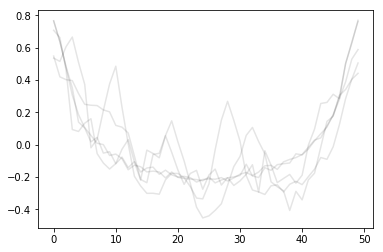

In [166]:
for i in range(5):
    plt.plot(lcs[:, i], alpha=0.1, color='k')
    print(spots_occulted)

In [167]:
X = lcs.T[:, :, np.newaxis] 
X -= np.array(X).mean()
X /= X.ptp()

predict_y = model.predict(X)
correct = np.argmax(predict_y, axis=1).astype(bool) == np.array(truth)
print(np.count_nonzero(correct)/len(correct))
print(correct)

# for i, x in enumerate(X): 
#     plt.title(str(np.argmax(predict_y, axis=1)[i]) +' '+ 
#               str(np.argmax(predict_y, axis=1)[i] == truth[i]))
#     plt.plot(x)
#     plt.show()

# X = np.random.randn(*X.shape)

0.936
[ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True False  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  T